### BREAST CANCER DETECTION.

#### About Dataset

 Worldwide, breast cancer is the most common type of cancer in women and the second highest in terms of mortality rates.Diagnosis of breast cancer is performed when an abnormal lump is found (from self-examination or x-ray) or a tiny speck of calcium is seen (on an x-ray). After a suspicious lump is found, the doctor will conduct a diagnosis to determine whether it is cancerous and, if so, whether it has spread to other parts of the body.

This breast cancer dataset was obtained from the University of Wisconsin Hospitals, Madison from Dr. William H. Wolberg.

In [49]:
#Essential libraries for data manipulation and visualization
import numpy as np  # For numerical computations and array handling
import pandas as pd  # For working with dataframes (tabular data)

#Plotting and visualization libraries
import matplotlib.pyplot as plt  # For basic plotting
import seaborn as sns  # For enhanced visualizations with built-in themes

#Preprocessing and model selection 
from sklearn.preprocessing import StandardScaler  # For scaling features before model training
from sklearn.model_selection import train_test_split  #To split dataset into training and test sets

#Modeling libraries
from sklearn.linear_model import LogisticRegression  #Logistic regression classifier
from sklearn.model_selection import GridSearchCV  #For hyperparameter tuning using grid search

#Evaluation metrics and tools
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix #For confusion matrix generation and display
from sklearn.metrics import classification_report #For precision, recall, f1-score, and accuracy
from sklearn.metrics import roc_curve, auc #For plotting ROC curve and calculating AUC

#CatBoost classifier
from catboost import CatBoostClassifier #A gradient boosting classifier that handles categorical variables efficiently

#Saving the model
import joblib  # For saving and loading trained models (serialization)



#### Laoding Data

In [50]:
df = pd.read_csv("../data/Breast_cancer_data.csv")

In [51]:
df.head(3)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.8,1001.0,0.11840,0
1,20.57,17.77,132.9,1326.0,0.08474,0
2,19.69,21.25,130.0,1203.0,0.10960,0


### Renaming columns

In [52]:
#Renaming columns for better readability by replacing underscores with spaces
df = df.rename(columns={
    "mean_radius": "mean radius",
    "mean_texture": "mean texture",
    "mean_area": "mean area",
    "mean_smoothness": "mean smoothness",
    "mean_perimeter": "mean perimeter"
})


In [53]:
#Generating descriptive statistics (count, mean, std, min, max, etc.) for each feature
#Transposing the result so each feature is a row and each statistic is a column (better readability)
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.98100,11.70000,13.37000,15.7800,28.1100
mean texture,569.0,19.289649,4.301036,9.71000,16.17000,18.84000,21.8000,39.2800
mean perimeter,569.0,91.969033,24.298981,43.79000,75.17000,86.24000,104.1000,188.5000
mean area,569.0,654.889104,351.914129,143.50000,420.30000,551.10000,782.7000,2501.0000
mean smoothness,569.0,0.096360,0.014064,0.05263,0.08637,0.09587,0.1053,0.1634
diagnosis,569.0,0.627417,0.483918,0.00000,0.00000,1.00000,1.0000,1.0000


c:\Users\user\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


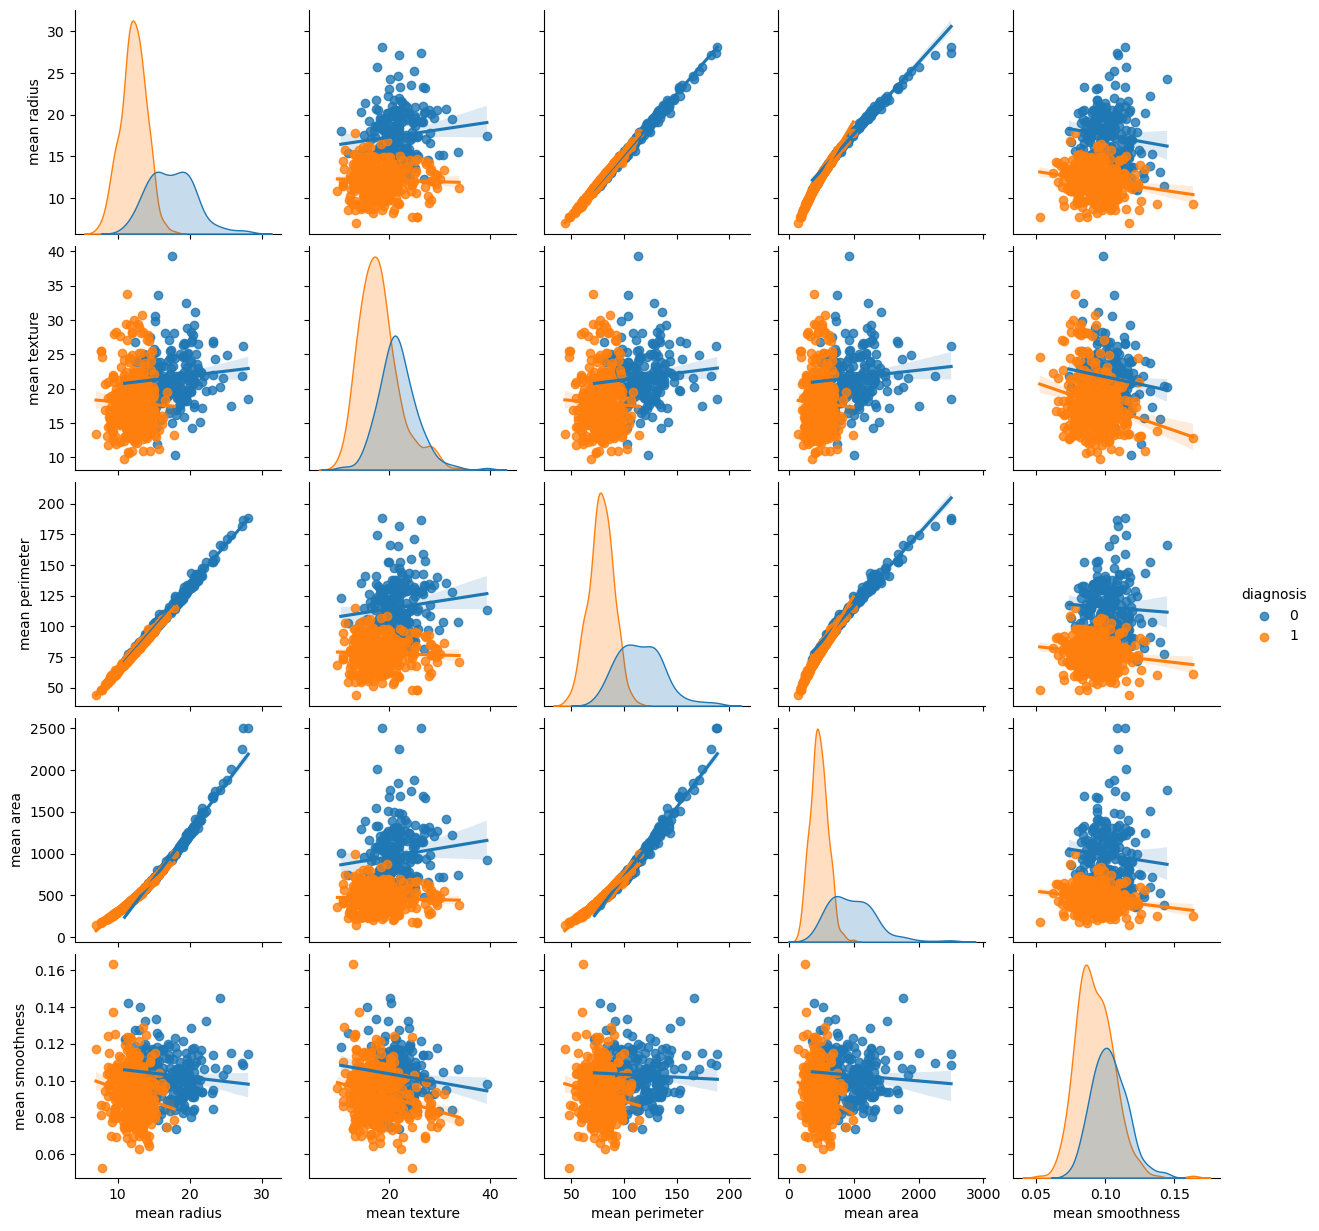

In [54]:
#Creating a pairplot to visualize pairwise relationships between features
#'kind="reg"' adds regression lines to scatter plots
#'hue="diagnosis"' colors the points based on diagnosis (e.g., malignant vs. benign)
sns.pairplot(df, kind='reg', hue="diagnosis");

Above are the summary statistics for our dataset. We have 569 entries in total and five features. Four features are numeric and one is categorical.

#### Checking for missing data.

In [55]:
#Checking for missing (null) values in each column of the dataset
df.isnull().sum()


mean radius        0
mean texture       0
mean perimeter     0
mean area          0
mean smoothness    0
diagnosis          0
dtype: int64

##### There are no missing values in our dataset

##### Plotting a correlation heatmap.

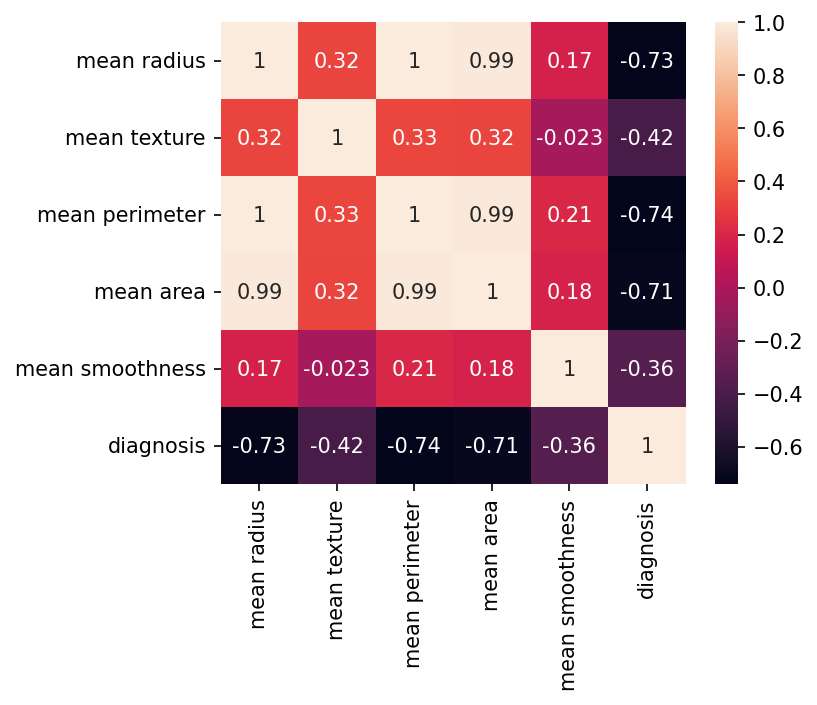

In [56]:
plt.figure(figsize=(5, 4), dpi=150)
#Generating a heatmap of the correlation matrix between all numerical features
#annotation adds the correlation values inside each cell for interpretation
sns.heatmap(df.corr(), annot=True);


In [57]:
df.corr()["diagnosis"].sort_values(ascending=True)

mean perimeter    -0.742636
mean radius       -0.730029
mean area         -0.708984
mean texture      -0.415185
mean smoothness   -0.358560
diagnosis          1.000000
Name: diagnosis, dtype: float64

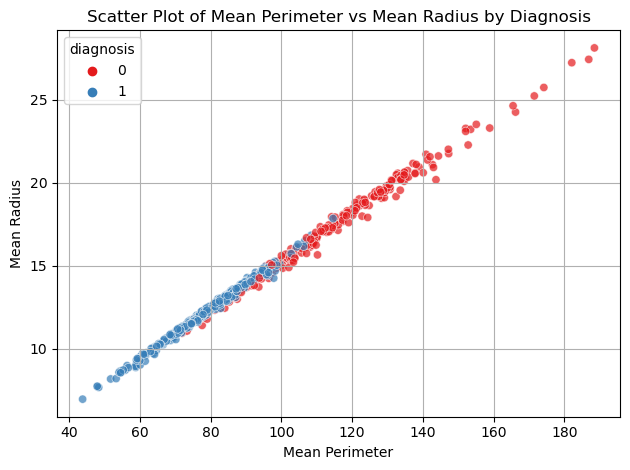

In [58]:
# Scatter plot showing the relationship between mean perimeter and mean radius
sns.scatterplot(
    x="mean perimeter",
    y="mean radius",
    data=df,
    hue="diagnosis",
    palette="Set1",
    alpha=0.7     
)
plt.title("Scatter Plot of Mean Perimeter vs Mean Radius by Diagnosis")
plt.xlabel("Mean Perimeter")
plt.ylabel("Mean Radius")
plt.grid(True)
plt.tight_layout()
plt.show()


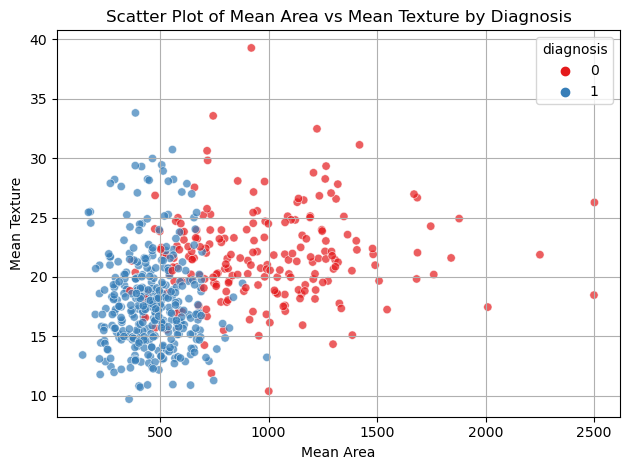

In [59]:
# Scatter plot showing the relationship between mean area and mean texture
sns.scatterplot(
    x="mean area",
    y="mean texture",
    data=df,
    hue="diagnosis",
    palette="Set1",
    alpha=0.7
)
plt.title("Scatter Plot of Mean Area vs Mean Texture by Diagnosis")
plt.xlabel("Mean Area")
plt.ylabel("Mean Texture")
plt.grid(True)
plt.tight_layout()
plt.show()


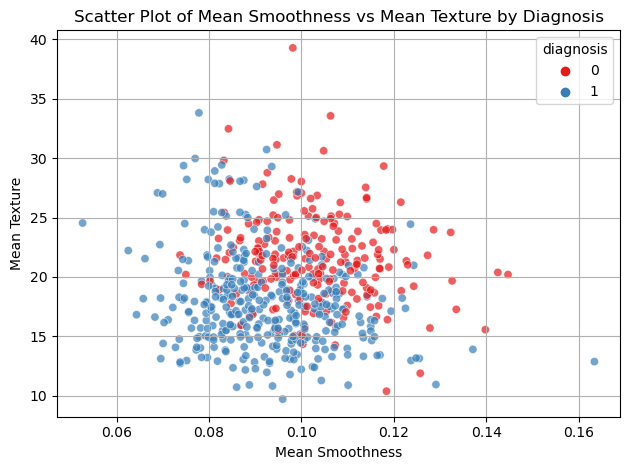

In [60]:
# Scatter plot of mean smoothness vs mean texture, colored by diagnosis
sns.scatterplot(
    x="mean smoothness",
    y="mean texture",
    data=df,
    hue="diagnosis",
    palette="Set1",
    alpha=0.7
)
plt.title("Scatter Plot of Mean Smoothness vs Mean Texture by Diagnosis")
plt.xlabel("Mean Smoothness")
plt.ylabel("Mean Texture")
plt.grid(True)
plt.tight_layout()
plt.show()


### Fitting a logistic regression model
A preferred base model for this particular dataset is `logistic regression` because the dataset has an outcome variable as a binary value.

### Separating data features.

In [61]:
#Splitting the data: 75% for training, 25% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=101)

In [62]:

#Initializing the standard scaler
scaler = StandardScaler()

#### Splitting data into training and test sets.

In [63]:
#Data has been split such that 25% is used for testing and 75% for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#Initializing the logistic regression model
log_model = LogisticRegression()
#Defining a parameter grid for hyperparameter tuning
parameter_grid = {
    'C': list([i/10 for i in range(101)]),#Inverse of regularization strength (lower = stronger regularization)
    'penalty': ['l1', 'l2','elasticnet'], #Regularization types
    'solver': ['liblinear', 'saga'], #Solver supporting the selected penalties
    'max_iter': list([i * 10 for i in range(11)])#Number of iterations to converge
}

In [ ]:
#Setting up grid search for logistic regression
grid_model = GridSearchCV(
    estimator=log_model,#Base logistic regression model
    param_grid=parameter_grid,#Hyperparameter combinations to try
    cv=5,#5-fold cross-validation
    scoring='accuracy',#Evaluation metric
    verbose=1 #Verbosity to show progress
)


In [66]:
#Fitting the grid search to the training data
grid_model.fit(X_train, y_train)


Fitting 5 folds for each of 6666 candidates, totalling 33330 fits


c:\Users\user\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                               1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9,
                               2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, ...],
                         'max_iter': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                      100],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [67]:
#Getting dictionary of the best hyperparameter combination found during the grid search.
grid_model.best_params_

{'C': 9.3, 'max_iter': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Best performing model had these parameters Regularization parameter of 6.6 , Regularization type is L1 , solver as liblinear.

In [68]:
#Retrieving the best logistic regression model after hyperparameter tuning
optimal_model = grid_model.best_estimator_

In [69]:
#Calculating the accuracy score on the test data
accuracy_score = optimal_model.score(X_test, y_test)
#Displaying the test accuracy
accuracy_score


0.9090909090909091

In [70]:
#Generating predictions on the test set using the optimal logistic regression model
predictions = optimal_model.predict(X_test)


In [71]:
#Getting classification report.
print("classification_report")
print(classification_report(y_test, predictions,target_names=['Benign (0)', 'Malignant (1)']))

classification_report
               precision    recall  f1-score   support

   Benign (0)       0.88      0.89      0.88        55
Malignant (1)       0.93      0.92      0.93        88

     accuracy                           0.91       143
    macro avg       0.90      0.91      0.90       143
 weighted avg       0.91      0.91      0.91       143



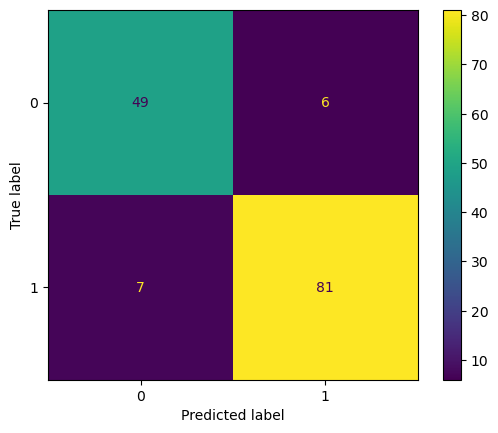

In [72]:
#Generating the confusion matrix
cm = confusion_matrix(y_test, predictions)
#Creating a display object for the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#Plotting the confusion matrix
disp.plot()

Our model performed with an accuracy of 91.6%

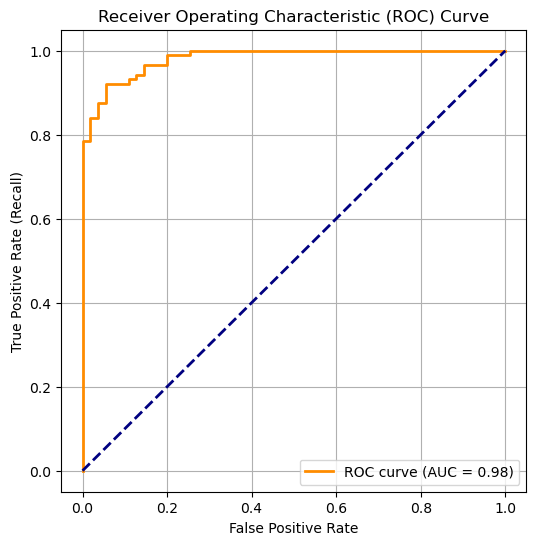

In [73]:
#Getting predicted probabilities for the positive class (Malignant = 1)
y_proba = optimal_model.predict_proba(X_test)[:, 1]

#Computing the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

#Calculating the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

#Plotting the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


The above AUC value of 0.98 means that the model performs excellently and has a very high ability of distinguishing between malignant and benign tumors.

### Fitting a CatBoostClassifier with Grid Search

In [ ]:
#Initialize the CatBoostClassifier
#verbose=0 disables training output
cat_model = CatBoostClassifier(verbose=0, random_state=42)
#Defining a hyperparameter grid for tuning with GridSearchCV
cat_param_grid = {
    'iterations': [1, 10, 100],#Number of boosting iterations (trees)
    'learning_rate': [0.01, 0.05, 0.1],#Step size shrinkage to prevent overfitting
    'depth': [3, 4, 7, 10],#Depth of the individual trees
    'l2_leaf_reg': [1, 4, 5] #L2 regularization coefficient
}


In [ ]:
#Setting up GridSearchCV for CatBoostClassifier
cat_grid = GridSearchCV(
    estimator=cat_model,
    param_grid=cat_param_grid,
    scoring='accuracy', #Optimizing for accuracy
    cv=3,#3-fold cross-validation
    verbose=0,#Showing progress logs
    n_jobs=-1 #Using all available CPU cores for parallel processing
)

#Fittiing the grid search to the training data
cat_grid.fit(X_train, y_train)
#Extracting the best-performing CatBoost model
best_cat = cat_grid.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits


['best_cat.pkl']

In [81]:
#Saving the best model.
joblib.dump(best_cat, "../utils/mbest_cat.pkl")

['../utils/mbest_cat.pkl']

In [ ]:
#Predicting on the test set using the best CatBoost model
cat_model_predictions = cat_grid.predict(X_test)
print("classification_report:")
print(classification_report(y_test, cat_model_predictions,target_names=['Benign (0)', 'Malignant (1)']))

classification_report:
               precision    recall  f1-score   support

   Benign (0)       0.89      0.87      0.88        55
Malignant (1)       0.92      0.93      0.93        88

     accuracy                           0.91       143
    macro avg       0.91      0.90      0.90       143
 weighted avg       0.91      0.91      0.91       143



In [78]:
print(f"Best model parameters{cat_grid.best_params_}")

Best model parameters{'depth': 4, 'iterations': 100, 'l2_leaf_reg': 4, 'learning_rate': 0.05}


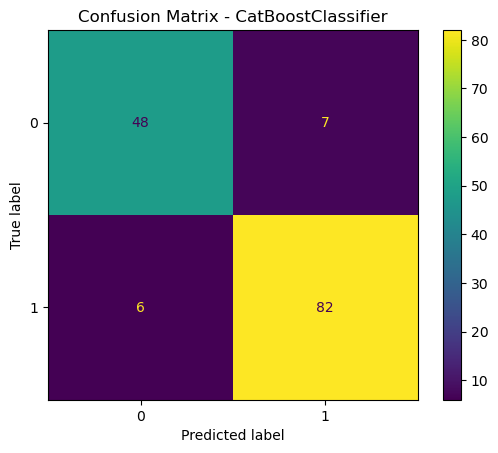

In [83]:
#Generating the confusion matrix for CatBoost predictions
cm_cat = confusion_matrix(y_test, cat_model_predictions)
#Creating and displaying the confusion matrix plot
disp_cat = ConfusionMatrixDisplay(confusion_matrix=cm_cat)
disp_cat.plot()
plt.title("Confusion Matrix - CatBoostClassifier")
plt.grid(False)
plt.show()

True Negatives (TN = 48): Benign tumors correctly predicted.

False Positives (FP = 6): Benign tumors misclassified as malignant.

False Negatives (FN = 7): Malignant tumors misclassified as benign – potentially dangerous.

True Positives (TP = 82): Malignant tumors correctly identified.

In [85]:
cat_accuracy = best_cat.score(X_test, y_test)
cat_accuracy

0.9090909090909091

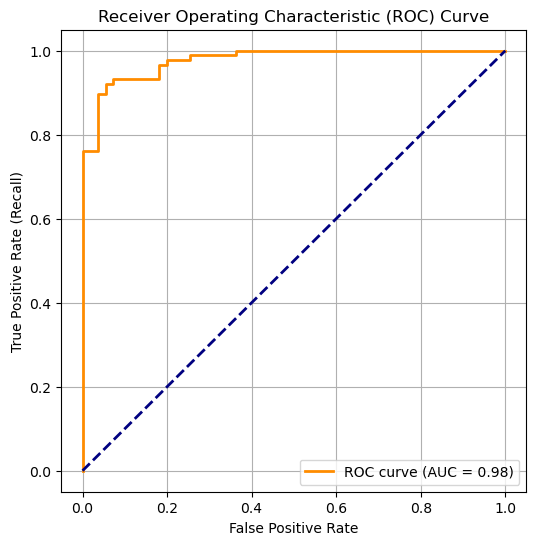

In [ ]:
# Pltting ROC for CatBoostClassifier curve.
y_proba = best_cat_model.predict_proba(X_test)[:, 1]  # probability for class 1 (malignant)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

The above AUC value of 0.98 means that the model performs excellently and has a very high ability of distinguishing between malignant and benign tumors.

CatBoostClasifier managed an accuracy score of 90.91 which is slightly lower than the  logistic regression model. Will make use of logistic regression model. Both had similar classifications and misclassifications as showed by the confusion matrix above

✅ Conclusion:

While both models perform exceptionally well, CatBoost slightly outperforms logistic regression in reducing false negatives — a critical win in cancer detection. For this case I will work with CatBoost model in building my streamlit app.

### Fitting model on the whole dataset.

In [86]:
#Initializing CatBoost with optimal parameters from grid search
cat_boost_model = CatBoostClassifier(
    depth=4,#will control tree depth (complexity vs overfitting)
    iterations=100,#Number of boosting iterations (trees)
    l2_leaf_reg=4,#L2 regularization (helps prevent overfitting)
    learning_rate=0.05, #Step size for gradient descent
    random_state=42, #Ensuring reproducibility
    verbose=0 #Silencing training output
)

In [87]:
#Fitting on the full dataset (X and y) initially transformed
cat_boost_model.fit(X,y)

### Saving our model and loading in order to test its performance.

In [91]:
#Saving the CatBoost model to the utils folder
joblib.dump(cat_boost_model, "../utils/cat_boost_model.pkl")

cat_boost = joblib.load("../utils/cat_boost_model.pkl")

In [92]:
#Creating a copy of the first row of the dataset (for testing)
df1 = df.head(1) #this will be used as input (features only)
df2 = df.head(1)  #this will retain the target for comparison
#Viewing the actual label (diagnosis) of the first sample
print("True Diagnosis:", df2['diagnosis'].values[0])
#Removing the target column so df1 contains only features
df1 = df1.drop("diagnosis", axis=1)
#Display the input features
print("Input Features:")
print(df1)

True Diagnosis: 0
Input Features:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness
0        17.99         10.38           122.8     1001.0           0.1184


In [94]:
#Predicting the diagnosis for the first row (excluding the target column)
cat_boost.predict(df1)

array([0], dtype=int64)

The prediction from our model is 0 implying benign which is the correct prediction according to the first row.

In [96]:
#Retrieving columns
columns = list(X.columns)

In [ ]:
#Saving the feature column names list to the utils folder
joblib.dump(columns, "../utils/columns.pkl")

['../utils/columns.pkl']